In [1]:
from collections import defaultdict
import inspect
import itertools
import os
import re
import subprocess
import sys

import nltk
from nltk.tokenize import WhitespaceTokenizer
import NERDA
import pandas as pd
import seaborn
import sqlite3

In [2]:
print(os.getcwd())
os.getcwd()
%ls

/Users/kaze7539/proj/bri/newa
README.md
__init__.py
__pycache__/
abe_bigram_naive_bayes_and_maxent.ipynb
abe_simple_naive_bayes.ipynb
backward_decoding.ipynb
conlleval.pl*
conllresults.eps
conllresults.pdf
conllresults.png
conllresults.svg
conllresultsclean.pdf
conllresultsclean2.pdf
exploreNewa.ipynb
for_ml/
good_length.txt
just_ec.conll
ki.txt
ki_true.txt
lined_up.txt
new_dedup.txt
newfile.txt
rerun_using_bri_partitions.ipynb
results.db
run_all_experiments.ipynb
sp1/
test_conll.txt
test_conll.txt~
tmp.pdf
tmp.txt
tmp.txt~
tmp1.txt
tmp1.txt~
util.py
util.py~
verb_counts_and_translations.ipynb


In [3]:
sys.path.append(".")
print(sys.path)
import util # library/module with recorded experiments and helper functions

['/Users/kaze7539/proj/bri/newa', '/usr/local/opt/python@3.8/Frameworks/Python.framework/Versions/3.8/lib/python38.zip', '/usr/local/opt/python@3.8/Frameworks/Python.framework/Versions/3.8/lib/python3.8', '/usr/local/opt/python@3.8/Frameworks/Python.framework/Versions/3.8/lib/python3.8/lib-dynload', '', '/Users/kaze7539/.virtualenvs/bri/lib/python3.8/site-packages', '/Users/kaze7539/.virtualenvs/bri/lib/python3.8/site-packages/IPython/extensions', '/Users/kaze7539/.ipython', '.']


In [4]:
# here are all the experiments that have been saved in util.py
experiments = sorted([item for item in dir(util) if item.startswith("experiment")])
print(experiments)


['experiment_001_naive_bayes_unigram', 'experiment_002_naive_bayes_pseudo_bigram_dishonest', 'experiment_002_naive_bayes_pseudo_bigram_honest', 'experiment_003_maxent_pseudo_bigram', 'experiment_004_maxent_bigram', 'experiment_005_bri_nerda', 'experiment_011_maxent_unigram', 'experiment_011_naive_bayes_unigram', 'experiment_012_naive_bayes_pseudo_bigram_dishonest', 'experiment_012_naive_bayes_pseudo_bigram_honest', 'experiment_013_maxent_pseudo_bigram', 'experiment_014_maxent_bigram', 'experiment_014_naivebayes_bigram', 'experiment_016_maxent_trigram', 'experiment_016_naivebayes_trigram', 'experiment_022_naive_bayes_pseudo_bigram_dishonest_backward', 'experiment_022_naive_bayes_pseudo_bigram_honest_backward', 'experiment_023_maxent_pseudo_bigram_backward', 'experiment_024_maxent_bigram_backward', 'experiment_024_naivebayes_bigram_backward', 'experiment_025_maxent_trigram_backward', 'experiment_025_naivebayes_trigram_backward']


In [5]:
# create a database to store the results
connection = sqlite3.connect("results.db")
cursor = connection.cursor()
cursor.execute('''
    create table if not exists conlleval
    (
      experiment_name text not null,
      num_tokens integer not null,
      num_phrases integer not null,
      num_found integer not null,
      num_correct integer not null,
      accuracy real not null,
      precision real not null,
      recall real not null,
      fb1 real not null,
      constraint conlleval_pk primary key (experiment_name)
    );
    ''')

In [6]:
for experiment_name in experiments:
    print(experiment_name)
    cursor.execute("select * from conlleval where experiment_name = ?", (experiment_name, ))
    results = cursor.fetchone()
    if results: # if you want to rerun all the experiments delete the database file
        print("results cached", results)
    else:
        #results = globals()[experiment_name]()
        results = getattr(util, experiment_name)() # getattr gets the experiment from util module, () runs it
        cursor.execute("""
            insert into conlleval
            (experiment_name,  num_tokens, num_phrases, num_found, num_correct, accuracy, precision, recall, fb1)
            values (
            :experiment_name,
            :num_tokens,
            :num_phrases,
            :num_found,
            :num_correct,
            :accuracy,
            :precision,
            :recall,
            :fb1
            );
        """, results)
        print(results)
        connection.commit()

experiment_001_naive_bayes_unigram
results cached ('experiment_001_naive_bayes_unigram', 711, 33, 126, 0, 52.88, 0.0, 0.0, 0.0)
experiment_002_naive_bayes_pseudo_bigram_dishonest
results cached ('experiment_002_naive_bayes_pseudo_bigram_dishonest', 711, 33, 40, 21, 97.33, 52.5, 63.64, 57.53)
experiment_002_naive_bayes_pseudo_bigram_honest
results cached ('experiment_002_naive_bayes_pseudo_bigram_honest', 711, 33, 33, 19, 84.39, 57.58, 57.58, 57.58)
experiment_003_maxent_pseudo_bigram
results cached ('experiment_003_maxent_pseudo_bigram', 711, 33, 41, 26, 83.12, 63.41, 78.79, 70.27)
experiment_004_maxent_bigram
results cached ('experiment_004_maxent_bigram', 711, 33, 37, 27, 89.73, 72.97, 81.82, 77.14)
experiment_005_bri_nerda
results cached ('experiment_005_bri_nerda', 242, 13, 16, 10, 96.28, 62.5, 76.92, 68.97)
experiment_011_maxent_unigram
results cached ('experiment_011_maxent_unigram', 268, 13, 52, 0, 52.24, 0.0, 0.0, 0.0)
experiment_011_naive_bayes_unigram
results cached ('experim

In [7]:
# read experiment data into pandas dataframe
df = pd.read_sql_query("SELECT * from conlleval", connection)
#print(df.melt.__doc__)

In [8]:
df

,experiment_name,num_tokens,num_phrases,num_found,num_correct,accuracy,precision,recall,fb1
0,experiment_001_naive_bayes_unigram,711,33,126,0,52.88,0.00,0.00,0.00
1,experiment_002_naive_bayes_pseudo_bigram_disho...,711,33,40,21,97.33,52.50,63.64,57.53
2,experiment_002_naive_bayes_pseudo_bigram_honest,711,33,33,19,84.39,57.58,57.58,57.58
3,experiment_003_maxent_pseudo_bigram,711,33,41,26,83.12,63.41,78.79,70.27
4,experiment_004_maxent_bigram,711,33,37,27,89.73,72.97,81.82,77.14
5,experiment_005_bri_nerda,242,13,16,10,96.28,62.50,76.92,68.97
6,experiment_011_naive_bayes_unigram,268,13,46,1,63.81,2.17,7.69,3.39
7,experiment_012_naive_bayes_pseudo_bigram_disho...,268,13,17,8,97.39,47.06,61.54,53.33
8,experiment_012_naive_bayes_pseudo_bigram_honest,268,13,13,8,85.45,61.54,61.54,61.54
9,experiment_013_maxent_pseudo_bigram,268,13,19,10,80.97,52.63,76.92,62.50


In [9]:
df.melt(id_vars=['experiment_name'], value_vars=["precision", "recall", "fb1"])

,experiment_name,variable,value
0,experiment_001_naive_bayes_unigram,precision,0.00
1,experiment_002_naive_bayes_pseudo_bigram_disho...,precision,52.50
2,experiment_002_naive_bayes_pseudo_bigram_honest,precision,57.58
3,experiment_003_maxent_pseudo_bigram,precision,63.41
4,experiment_004_maxent_bigram,precision,72.97
...,...,...,...
61,experiment_014_naivebayes_bigram,fb1,54.05
62,experiment_016_naivebayes_trigram,fb1,20.90
63,experiment_024_naivebayes_bigram_backward,fb1,7.69
64,experiment_025_maxent_trigram_backward,fb1,0.00


In [10]:
import seaborn as sbn

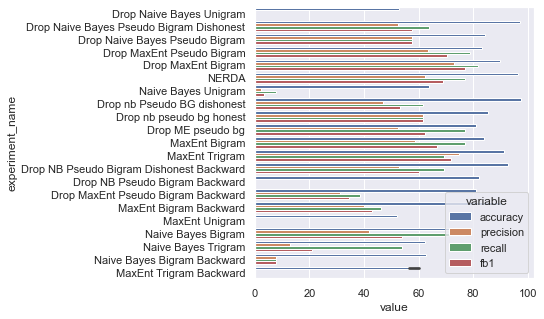

In [11]:
rename_dict = {'experiment_001_naive_bayes_unigram': 'Drop Naive Bayes Unigram',
              'experiment_002_naive_bayes_pseudo_bigram_dishonest': 'Drop Naive Bayes Pseudo Bigram Dishonest',
               'experiment_002_naive_bayes_pseudo_bigram_honest': 'Drop Naive Bayes Pseudo Bigram',
               'experiment_003_maxent_pseudo_bigram': 'Drop MaxEnt Pseudo Bigram',
               'experiment_004_maxent_bigram': 'Drop MaxEnt Bigram',
               'experiment_005_bri_nerda': 'NERDA',
               'experiment_011_naive_bayes_unigram': 'Naive Bayes Unigram',
               'experiment_012_naive_bayes_pseudo_bigram_dishonest': 'Drop nb Pseudo BG dishonest',
               'experiment_012_naive_bayes_pseudo_bigram_honest': 'Drop nb pseudo bg honest',
               'experiment_013_maxent_pseudo_bigram': 'Drop ME pseudo bg',
               'experiment_014_maxent_bigram': 'MaxEnt Bigram',
               'experiment_016_maxent_trigram': 'MaxEnt Trigram',
               'experiment_022_naive_bayes_pseudo_bigram_dishonest_backward': 'Drop NB Pseudo Bigram Dishonest Backward',
               'experiment_022_naive_bayes_pseudo_bigram_honest_backward': 'Drop NB Pseudo Bigram Backward',
               'experiment_023_maxent_pseudo_bigram_backward': 'Drop MaxEnt Pseudo Bigram Backward',
               'experiment_024_maxent_bigram_backward': 'MaxEnt Bigram Backward',
               'experiment_011_maxent_unigram': 'MaxEnt Unigram',
               'experiment_014_naivebayes_bigram': 'Naive Bayes Bigram',
               'experiment_016_naivebayes_trigram': 'Naive Bayes Trigram',
               'experiment_024_naivebayes_bigram_backward': 'Naive Bayes Bigram Backward',
               'experiment_025_maxent_trigram_backward': 'MaxEnt Trigram Backward',
               'experiment_025_naivebayes_trigram_backward': 'MaxEnt Trigram Backward',
               
              }
df_to_plot = df.replace(rename_dict)
sbn.set(rc={'figure.figsize':(5,5)}) # in inches
plot = sbn.barplot(
    data=df_to_plot.melt(id_vars=['experiment_name'], 
                                   value_vars=["accuracy","precision", "recall", "fb1"]), 
    y="experiment_name", 
    x="value", 
    hue="variable"
)

In [12]:
print(df_to_plot.to_latex(index=False))

\begin{tabular}{lrrrrrrrr}
\toprule
                         experiment\_name &  num\_tokens &  num\_phrases &  num\_found &  num\_correct &  accuracy &  precision &  recall &   fb1 \\
\midrule
                Drop Naive Bayes Unigram &         711 &           33 &        126 &            0 &     52.88 &       0.00 &    0.00 &  0.00 \\
Drop Naive Bayes Pseudo Bigram Dishonest &         711 &           33 &         40 &           21 &     97.33 &      52.50 &   63.64 & 57.53 \\
          Drop Naive Bayes Pseudo Bigram &         711 &           33 &         33 &           19 &     84.39 &      57.58 &   57.58 & 57.58 \\
               Drop MaxEnt Pseudo Bigram &         711 &           33 &         41 &           26 &     83.12 &      63.41 &   78.79 & 70.27 \\
                      Drop MaxEnt Bigram &         711 &           33 &         37 &           27 &     89.73 &      72.97 &   81.82 & 77.14 \\
                                   NERDA &         242 &           13 &         16 &  

In [13]:
import matplotlib.pyplot as plt
#import matplotlib as mpl
%matplotlib inline
#%matplotlib notebook

#dir(plt)
fig = plot.get_figure()
fig


#current.tight_layout(pad=5.5)

fig.savefig("conllresults.pdf", bbox_inches='tight')

In [14]:
plt.show()

## make a plot with only some of the experiments
and reorder them

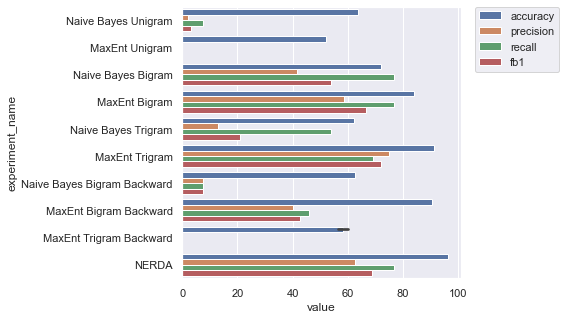

In [15]:
reorder_dict = {'experiment_001_naive_bayes_unigram': 1000,
              'experiment_002_naive_bayes_pseudo_bigram_dishonest': 1001,
               'experiment_002_naive_bayes_pseudo_bigram_honest': 1002,
               'experiment_003_maxent_pseudo_bigram': 1003,
               'experiment_004_maxent_bigram': 1004,
               'experiment_005_bri_nerda': 100,
               'experiment_011_naive_bayes_unigram': 50,
               'experiment_012_naive_bayes_pseudo_bigram_dishonest': 1005,
               'experiment_012_naive_bayes_pseudo_bigram_honest': 1006,
               'experiment_013_maxent_pseudo_bigram': 1007,
               'experiment_014_maxent_bigram': 61,
               'experiment_016_maxent_trigram': 71,
               'experiment_022_naive_bayes_pseudo_bigram_dishonest_backward': 1008,
               'experiment_022_naive_bayes_pseudo_bigram_honest_backward': 1009,
               'experiment_023_maxent_pseudo_bigram_backward': 1010,
                'experiment_024_naivebayes_bigram_backward': 80,
               'experiment_024_maxent_bigram_backward': 81,
               'experiment_011_maxent_unigram': 51,
               'experiment_014_naivebayes_bigram': 60,
               'experiment_016_naivebayes_trigram': 70,
               'experiment_025_maxent_trigram_backward': 82,
               'experiment_025_naivebayes_trigram_backward': 82,
               
              }
df_to_plot = df
df_to_plot['sort'] = df_to_plot['experiment_name'].map(reorder_dict)
df_to_plot = df_to_plot.sort_values(by=["sort"])
df_to_plot = df_to_plot.replace(rename_dict)
df_to_plot = df_to_plot[~df_to_plot["experiment_name"].str.startswith("Drop")]
sbn.set(rc={'figure.figsize':(5,5)}) # in inches
plot = sbn.barplot(
    data=df_to_plot.melt(id_vars=['experiment_name'], 
                                   value_vars=["accuracy","precision", "recall", "fb1"]), 
    y="experiment_name", 
    x="value", 
    hue="variable"
)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [16]:
df_to_plot


,experiment_name,num_tokens,num_phrases,num_found,num_correct,accuracy,precision,recall,fb1,sort
6,Naive Bayes Unigram,268,13,46,1,63.81,2.17,7.69,3.39,50
16,MaxEnt Unigram,268,13,52,0,52.24,0.00,0.00,0.00,51
17,Naive Bayes Bigram,268,13,24,10,72.01,41.67,76.92,54.05,60
10,MaxEnt Bigram,268,13,17,10,83.96,58.82,76.92,66.67,61
18,Naive Bayes Trigram,268,13,54,7,62.31,12.96,53.85,20.90,70
11,MaxEnt Trigram,268,13,12,9,91.42,75.00,69.23,72.00,71
19,Naive Bayes Bigram Backward,268,13,13,1,62.69,7.69,7.69,7.69,80
15,MaxEnt Bigram Backward,268,13,15,6,90.67,40.00,46.15,42.86,81
20,MaxEnt Trigram Backward,268,13,3,0,56.34,0.00,0.00,0.00,82
21,MaxEnt Trigram Backward,268,13,77,0,60.07,0.00,0.00,0.00,82


In [17]:
#dir(plt)
fig = plot.get_figure()



#current.tight_layout(pad=5.5)

fig.savefig("conllresultsclean.pdf", bbox_inches='tight')

In [18]:
print(df_to_plot[["experiment_name", "num_tokens", "num_phrases", "num_correct", "accuracy", "precision", "recall", "fb1"]].to_latex(index=False))

\begin{tabular}{lrrrrrrr}
\toprule
            experiment\_name &  num\_tokens &  num\_phrases &  num\_correct &  accuracy &  precision &  recall &   fb1 \\
\midrule
        Naive Bayes Unigram &         268 &           13 &            1 &     63.81 &       2.17 &    7.69 &  3.39 \\
             MaxEnt Unigram &         268 &           13 &            0 &     52.24 &       0.00 &    0.00 &  0.00 \\
         Naive Bayes Bigram &         268 &           13 &           10 &     72.01 &      41.67 &   76.92 & 54.05 \\
              MaxEnt Bigram &         268 &           13 &           10 &     83.96 &      58.82 &   76.92 & 66.67 \\
        Naive Bayes Trigram &         268 &           13 &            7 &     62.31 &      12.96 &   53.85 & 20.90 \\
             MaxEnt Trigram &         268 &           13 &            9 &     91.42 &      75.00 &   69.23 & 72.00 \\
Naive Bayes Bigram Backward &         268 &           13 &            1 &     62.69 &       7.69 &    7.69 &  7.69 \\
     Max

## make plot to leave out backwards models and unigrams

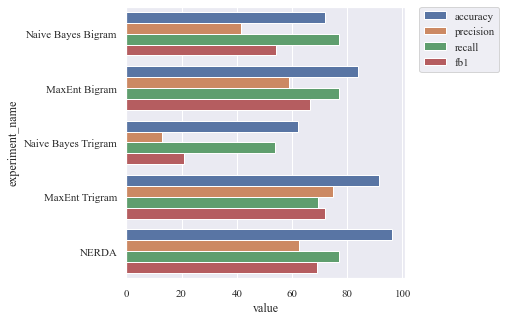

In [25]:
rename_dict = {'experiment_001_naive_bayes_unigram': 'Drop Naive Bayes Unigram',
              'experiment_002_naive_bayes_pseudo_bigram_dishonest': 'Drop Naive Bayes Pseudo Bigram Dishonest',
               'experiment_002_naive_bayes_pseudo_bigram_honest': 'Drop Naive Bayes Pseudo Bigram',
               'experiment_003_maxent_pseudo_bigram': 'Drop MaxEnt Pseudo Bigram',
               'experiment_004_maxent_bigram': 'Drop MaxEnt Bigram',
               'experiment_005_bri_nerda': 'NERDA',
               'experiment_011_naive_bayes_unigram': 'Drop Naive Bayes Unigram',
               'experiment_012_naive_bayes_pseudo_bigram_dishonest': 'Drop nb Pseudo BG dishonest',
               'experiment_012_naive_bayes_pseudo_bigram_honest': 'Drop nb pseudo bg honest',
               'experiment_013_maxent_pseudo_bigram': 'Drop ME pseudo bg',
               'experiment_014_maxent_bigram': 'MaxEnt Bigram',
               'experiment_016_maxent_trigram': 'MaxEnt Trigram',
               'experiment_022_naive_bayes_pseudo_bigram_dishonest_backward': 'Drop NB Pseudo Bigram Dishonest Backward',
               'experiment_022_naive_bayes_pseudo_bigram_honest_backward': 'Drop NB Pseudo Bigram Backward',
               'experiment_023_maxent_pseudo_bigram_backward': 'Drop MaxEnt Pseudo Bigram Backward',
               'experiment_024_maxent_bigram_backward': 'Drop MaxEnt Bigram Backward',
               'experiment_011_maxent_unigram': 'Drop MaxEnt Unigram',
               'experiment_014_naivebayes_bigram': 'Naive Bayes Bigram',
               'experiment_016_naivebayes_trigram': 'Naive Bayes Trigram',
               'experiment_024_naivebayes_bigram_backward': 'Drop Naive Bayes Bigram Backward',
               'experiment_025_maxent_trigram_backward': 'Drop MaxEnt Trigram Backward',
               'experiment_025_naivebayes_trigram_backward': 'Drop MaxEnt Trigram Backward',
               
              }
reorder_dict = {'experiment_001_naive_bayes_unigram': 1000,
              'experiment_002_naive_bayes_pseudo_bigram_dishonest': 1001,
               'experiment_002_naive_bayes_pseudo_bigram_honest': 1002,
               'experiment_003_maxent_pseudo_bigram': 1003,
               'experiment_004_maxent_bigram': 1004,
               'experiment_005_bri_nerda': 100,
               'experiment_011_naive_bayes_unigram': 50,
               'experiment_012_naive_bayes_pseudo_bigram_dishonest': 1005,
               'experiment_012_naive_bayes_pseudo_bigram_honest': 1006,
               'experiment_013_maxent_pseudo_bigram': 1007,
               'experiment_014_maxent_bigram': 61,
               'experiment_016_maxent_trigram': 71,
               'experiment_022_naive_bayes_pseudo_bigram_dishonest_backward': 1008,
               'experiment_022_naive_bayes_pseudo_bigram_honest_backward': 1009,
               'experiment_023_maxent_pseudo_bigram_backward': 1010,
                'experiment_024_naivebayes_bigram_backward': 80,
               'experiment_024_maxent_bigram_backward': 81,
               'experiment_011_maxent_unigram': 51,
               'experiment_014_naivebayes_bigram': 60,
               'experiment_016_naivebayes_trigram': 70,
               'experiment_025_maxent_trigram_backward': 82,
               'experiment_025_naivebayes_trigram_backward': 82,
               
              }
df_to_plot = df
df_to_plot['sort'] = df_to_plot['experiment_name'].map(reorder_dict)
df_to_plot = df_to_plot.sort_values(by=["sort"])
df_to_plot = df_to_plot.replace(rename_dict)
df_to_plot = df_to_plot[~df_to_plot["experiment_name"].str.startswith("Drop")]
sbn.set(rc={'figure.figsize':(5,5)}) # in inches
# try to fix issue with type 3 fonts
sbn.set(rc={'pdf.fonttype':42})
sbn.set(rc={'ps.fonttype':42})
sbn.set(font="Times New Roman")
        
#mpl.rcParams['pdf.fonttype'] = 42
#mpl.rcParams['ps.fonttype'] = 42
plot = sbn.barplot(
    data=df_to_plot.melt(id_vars=['experiment_name'], 
                                   value_vars=["accuracy","precision", "recall", "fb1"]), 
    y="experiment_name", 
    x="value", 
    hue="variable"
)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [26]:
fig = plot.get_figure()
fig.savefig("conllresultsclean4.pdf", bbox_inches='tight')
print(df_to_plot[["experiment_name", "num_tokens", "num_phrases", "num_correct", "accuracy", "precision", "recall", "fb1"]].to_latex(index=False))

\begin{tabular}{lrrrrrrr}
\toprule
    experiment\_name &  num\_tokens &  num\_phrases &  num\_correct &  accuracy &  precision &  recall &   fb1 \\
\midrule
 Naive Bayes Bigram &         268 &           13 &           10 &     72.01 &      41.67 &   76.92 & 54.05 \\
      MaxEnt Bigram &         268 &           13 &           10 &     83.96 &      58.82 &   76.92 & 66.67 \\
Naive Bayes Trigram &         268 &           13 &            7 &     62.31 &      12.96 &   53.85 & 20.90 \\
     MaxEnt Trigram &         268 &           13 &            9 &     91.42 &      75.00 &   69.23 & 72.00 \\
              NERDA &         242 &           13 &           10 &     96.28 &      62.50 &   76.92 & 68.97 \\
\bottomrule
\end{tabular}



In [23]:
import matplotlib as mpl
font_paths = mpl.font_manager.findSystemFonts()
print(font_paths)
font_objects = mpl.font_manager.createFontList(font_paths)
font_names = [f.name for f in font_objects]
print(font_names)

['/Library/Fonts/STIXIntSmReg.otf', '/System/Library/Fonts/SFNSDisplay-LightItalic.otf', '/usr/X11R6/lib/X11/fonts/TTF/luxisr.ttf', '/Users/kaze7539/Library/Fonts/OpenDyslexicMono-Regular.otf', '/Library/Fonts/STIXSizThreeSymReg.otf', '/System/Library/Fonts/SFNSDisplay-BlackItalic.otf', '/Library/Fonts/Verdana Italic.ttf', '/Library/Fonts/NotoSansDevanagari-Medium.ttf', '/System/Library/Fonts/SFNSDisplayCondensed-Regular.otf', '/Library/Fonts/Courier New Italic.ttf', '/usr/X11/lib/X11/fonts/TTF/luxirri.ttf', '/Library/Fonts/stheiti.ttf', '/System/Library/Fonts/SFNSTextCondensed-Light.otf', '/Library/Fonts/Oriya MN.ttc', '/System/Library/Fonts/SFNSDisplay-ThinG1.otf', '/usr/X11/lib/X11/fonts/TTF/VeraBd.ttf', '/Library/Fonts/Courier New.ttf', '/Library/Fonts/Arial Italic.ttf', '/Library/Fonts/STIXIntUpSmBol.otf', '/Library/Fonts/Telugu MN.ttc', '/System/Library/Fonts/ヒラギノ角ゴシック W5.ttc', '/System/Library/Fonts/SFNSSymbols-Heavy.otf', '/Library/Fonts/Georgia Bold Italic.ttf', '/System/Lib

AttributeError: module 'matplotlib.font_manager' has no attribute 'createFontList'

In [24]:
mpl.font_manager.findSystemFonts()

['/Library/Fonts/STIXIntSmReg.otf',
 '/System/Library/Fonts/SFNSDisplay-LightItalic.otf',
 '/usr/X11R6/lib/X11/fonts/TTF/luxisr.ttf',
 '/Users/kaze7539/Library/Fonts/OpenDyslexicMono-Regular.otf',
 '/Library/Fonts/STIXSizThreeSymReg.otf',
 '/System/Library/Fonts/SFNSDisplay-BlackItalic.otf',
 '/Library/Fonts/Verdana Italic.ttf',
 '/Library/Fonts/NotoSansDevanagari-Medium.ttf',
 '/System/Library/Fonts/SFNSDisplayCondensed-Regular.otf',
 '/Library/Fonts/Courier New Italic.ttf',
 '/usr/X11/lib/X11/fonts/TTF/luxirri.ttf',
 '/Library/Fonts/stheiti.ttf',
 '/System/Library/Fonts/SFNSTextCondensed-Light.otf',
 '/Library/Fonts/Oriya MN.ttc',
 '/System/Library/Fonts/SFNSDisplay-ThinG1.otf',
 '/usr/X11/lib/X11/fonts/TTF/VeraBd.ttf',
 '/Library/Fonts/Courier New.ttf',
 '/Library/Fonts/Arial Italic.ttf',
 '/Library/Fonts/STIXIntUpSmBol.otf',
 '/Library/Fonts/Telugu MN.ttc',
 '/System/Library/Fonts/ヒラギノ角ゴシック W5.ttc',
 '/System/Library/Fonts/SFNSSymbols-Heavy.otf',
 '/Library/Fonts/Georgia Bold Ita